In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter
from scipy.spatial.distance import cdist

def HarrisPointsDetector(image, threshold=0.01, k=0.059):
    """
    Implements Harris Corner Detector with:
    - Gaussian-weighted gradients (σ=0.5)
    - Orientation computation (in degrees)
    - 7x7 Non-maximum suppression

    Args:
        image (np.ndarray): Grayscale input image
        threshold (float): Threshold for corner strength R
        k (float): Harris constant

    Returns:
        keypoints (list of cv2.KeyPoint): List of keypoints with orientation
    """
    # 1. Compute Sobel gradients
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # 2. Products of gradients
    Ixx = gaussian_filter(Ix * Ix, sigma=0.5)
    Iyy = gaussian_filter(Iy * Iy, sigma=0.5)
    Ixy = gaussian_filter(Ix * Iy, sigma=0.5)

    # 3. Harris response
    detM = Ixx * Iyy - Ixy**2
    traceM = Ixx + Iyy
    R = detM - k * (traceM**2)

    # 4. Non-maximum suppression (7x7)
    R_max = maximum_filter(R, size=7)
    mask = (R == R_max) & (R > threshold * R.max())

    # 5. Keypoint list with orientation
    keypoints = []
    ys, xs = np.where(mask)
    for y, x in zip(ys, xs):
        angle = np.degrees(np.arctan2(Iy[y, x], Ix[y, x])) % 360
        kp = cv2.KeyPoint(x=float(x), y=float(y), size=3, angle=angle)
        keypoints.append(kp)

    return keypoints

In [21]:
def plot_harris_threshold_curve(image, thresholds):
    counts = []
    for t in thresholds:
        kps = HarrisPointsDetector(image, threshold=t)
        counts.append(len(kps))
    plt.plot(thresholds, counts, marker='o')
    plt.xlabel("Threshold (relative to max R)")
    plt.ylabel("Number of Keypoints")
    plt.title("Harris Keypoints vs Threshold")
    plt.grid(True)
    plt.show()

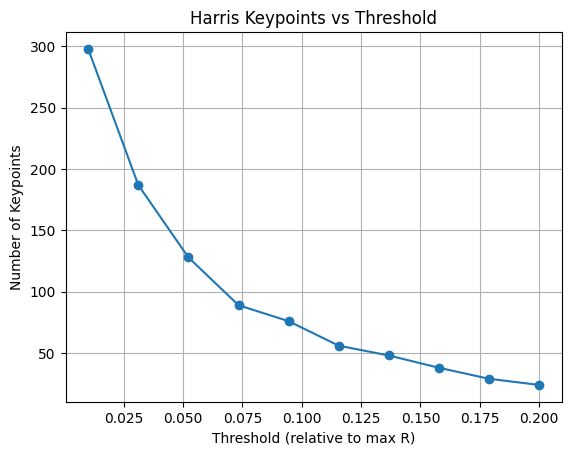

In [22]:
plot_harris_threshold_curve(gray, np.linspace(0.01, 0.2, 10))

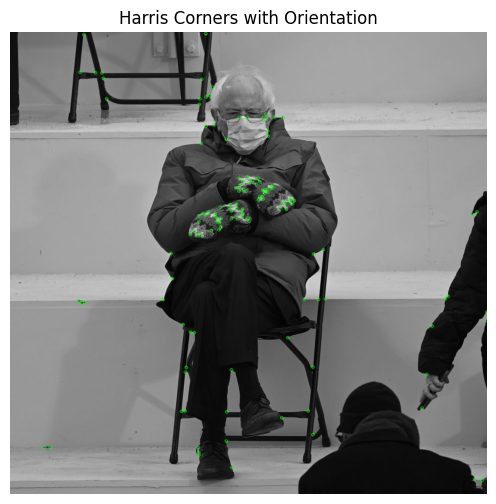

Detected 133 keypoints.


In [23]:
# Load image
gray = cv2.imread("images/bernieSanders.jpeg", cv2.IMREAD_GRAYSCALE)

# Detect Harris keypoints
keypoints = HarrisPointsDetector(gray, threshold=0.05)

# Visualize
out = cv2.drawKeypoints(gray, keypoints, None, color=(0,255,0))
plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.title("Harris Corners with Orientation")
plt.axis('off')
plt.show()

print(f"Detected {len(keypoints)} keypoints.")

In [24]:
def compute_ORB_descriptors(image, keypoints):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.compute(image, keypoints)
    return keypoints, descriptors

In [99]:
def show_keypoints(image, keypoints, title="Keypoints"):
    out = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
    plt.figure(figsize=(8, 6))
    plt.imshow(out)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [81]:
def SSDFeatureMatcher(desc1, desc2):
    distances = cdist(desc1.astype(np.float32), desc2.astype(np.float32), 'sqeuclidean')
    matches = []
    for i in range(distances.shape[0]):
        min_idx = np.argmin(distances[i])
        match = cv2.DMatch(_queryIdx=i, _trainIdx=min_idx, _distance=distances[i, min_idx])
        matches.append(match)
        matches = sorted(matches, key=lambda x: x.distance)
    good_matches = matches[:50]  # Keep top 50

    
    return good_matches

In [89]:
def RatioFeatureMatcher(desc1, desc2, ratio_thresh=0.7):
    distances = cdist(desc1.astype(np.float32), desc2.astype(np.float32), 'sqeuclidean')
    matches = []
    for i in range(distances.shape[0]):
        sorted_idx = np.argsort(distances[i])[:2]
        d1, d2 = distances[i][sorted_idx[0]], distances[i][sorted_idx[1]]
        if d1 < ratio_thresh * d2:
            match = cv2.DMatch(_queryIdx=i, _trainIdx=sorted_idx[0], _distance=d1)
            matches.append(match)
    return matches


In [90]:
def draw_matches(img1, kp1, img2, kp2, matches, title="Matches"):
    matched = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(matched, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [103]:
def compare_features(img):
    img1 = cv2.imread("images/bernieSanders.jpeg", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f"images/{img}", cv2.IMREAD_GRAYSCALE)

    # Harris keypoints
    kp1 = HarrisPointsDetector(img1, threshold=0.05)
    kp2 = HarrisPointsDetector(img2, threshold=0.05)

    # ORB descriptors
    kp1, desc1 = compute_ORB_descriptors(img1, kp1)
    kp2, desc2 = compute_ORB_descriptors(img2, kp2)

    # Match
    matches_ratio = RatioFeatureMatcher(desc1, desc2)
    matches_ssd = SSDFeatureMatcher(desc1, desc2)

    # Visualize
    draw_matches(img1, kp1, img2, kp2, matches_ratio, title="Harris + ORB + Ratio Matching")
    print(len(matches_ratio))
    draw_matches(img1, kp1, img2, kp2, matches_ssd, title="Harris + ORB + SSD Matching")
    print(len(matches_ssd))


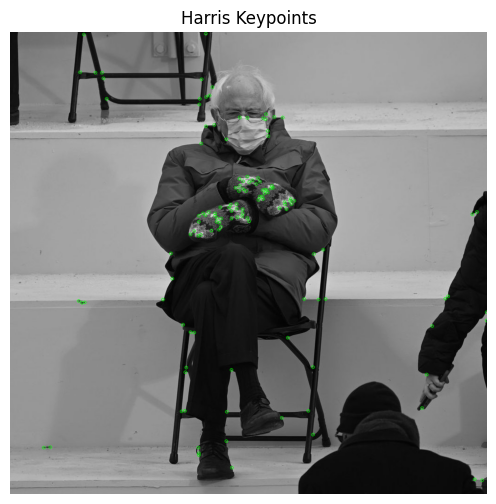

In [106]:
image=cv2.imread("images/bernieSanders.jpeg", cv2.IMREAD_GRAYSCALE)
keypoints=HarrisPointsDetector(image, threshold=0.05)
show_keypoints(image,keypoints , title="Harris Keypoints")

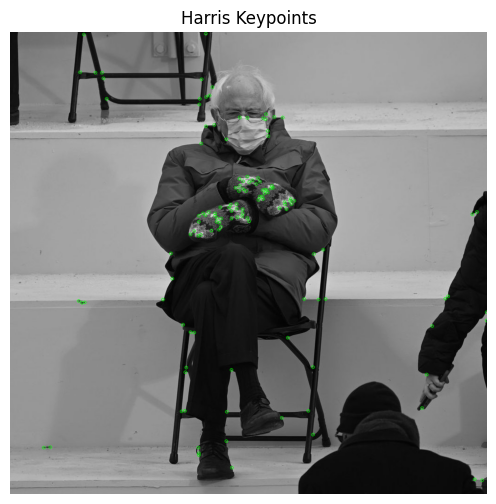

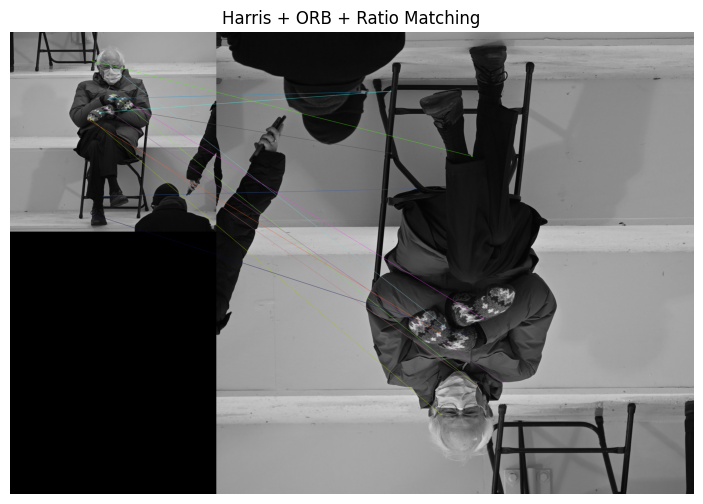

13


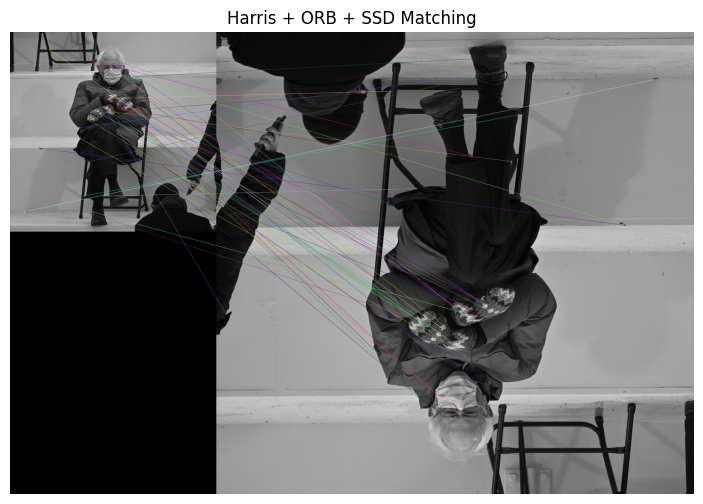

50


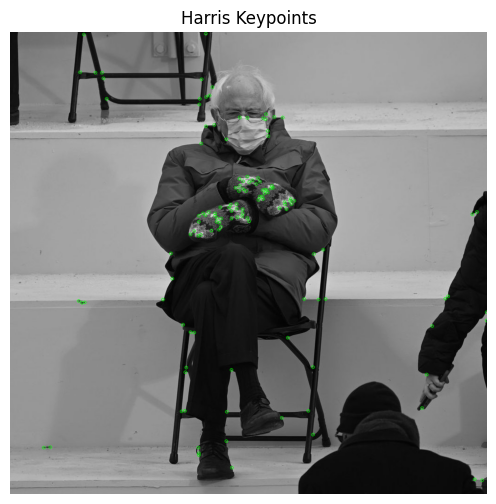

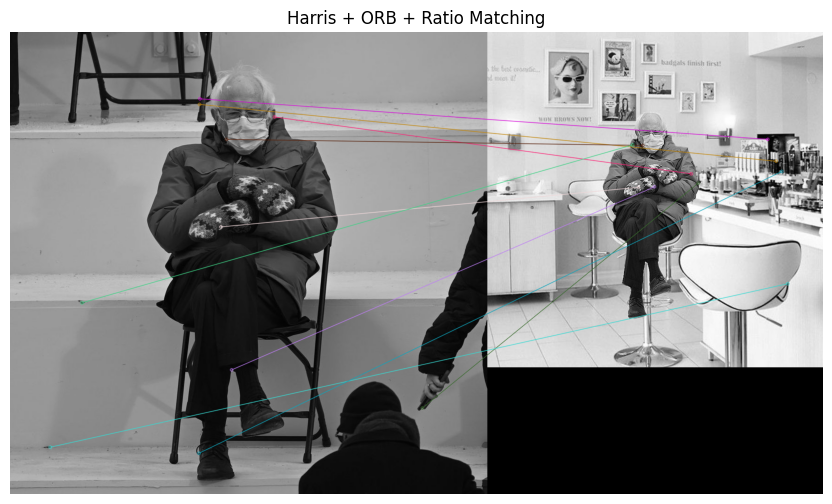

10


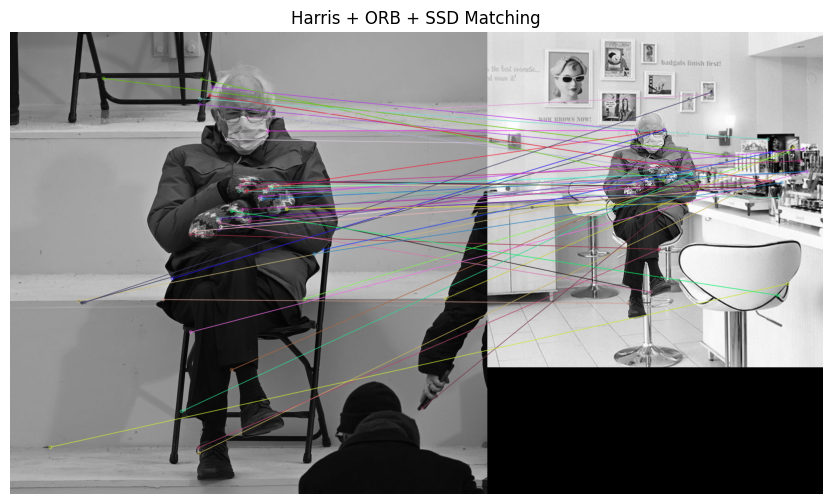

50


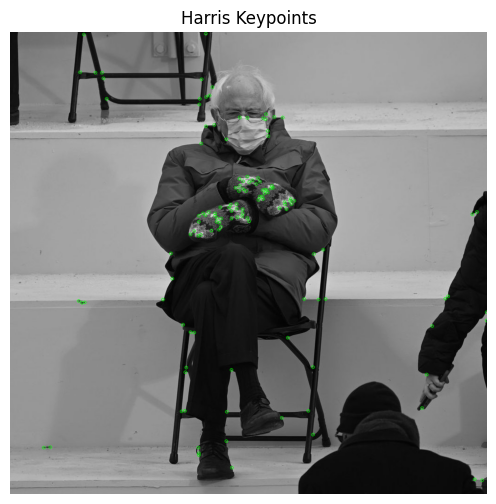

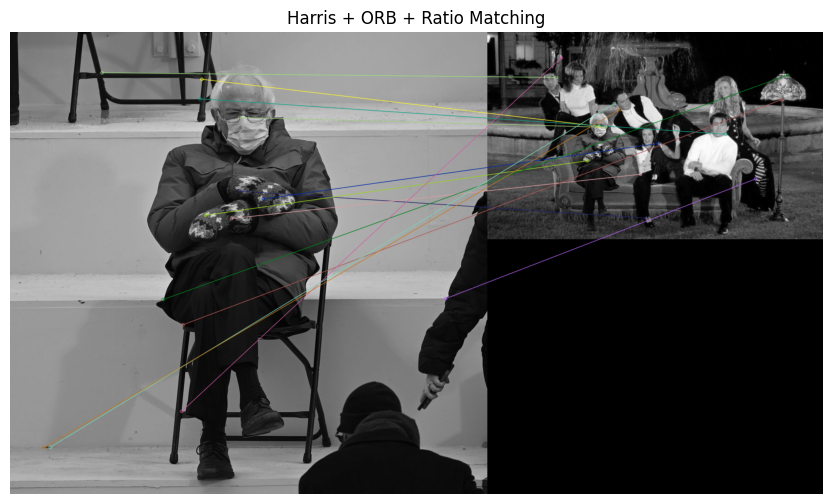

14


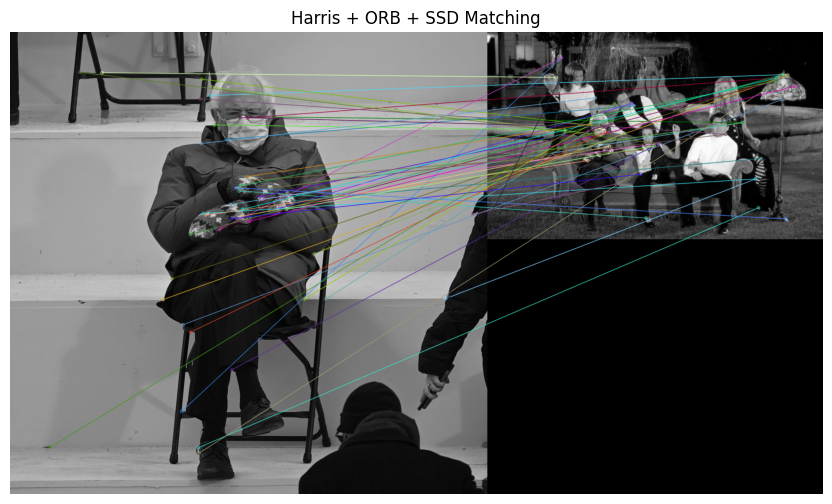

50


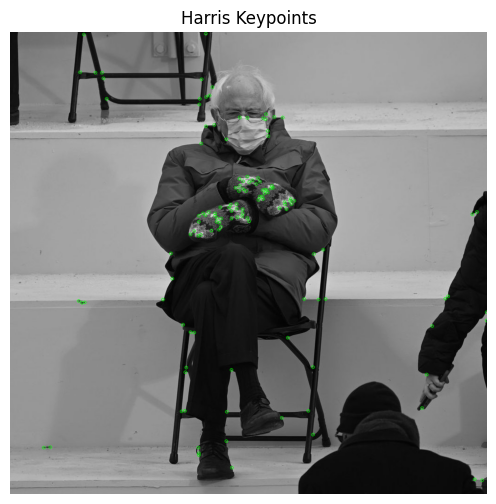

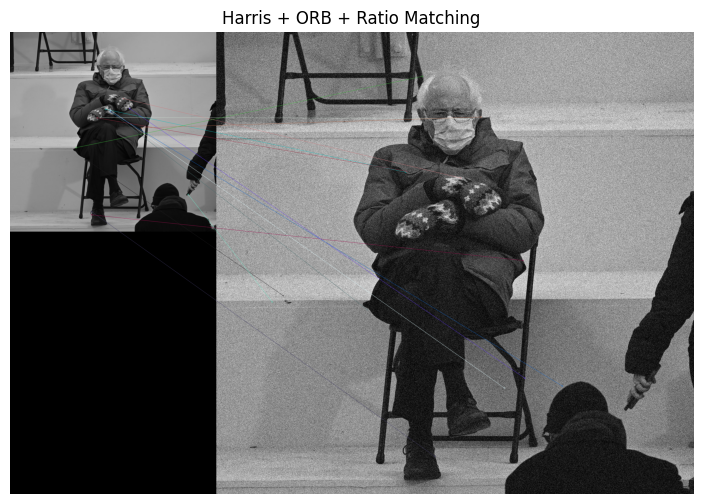

14


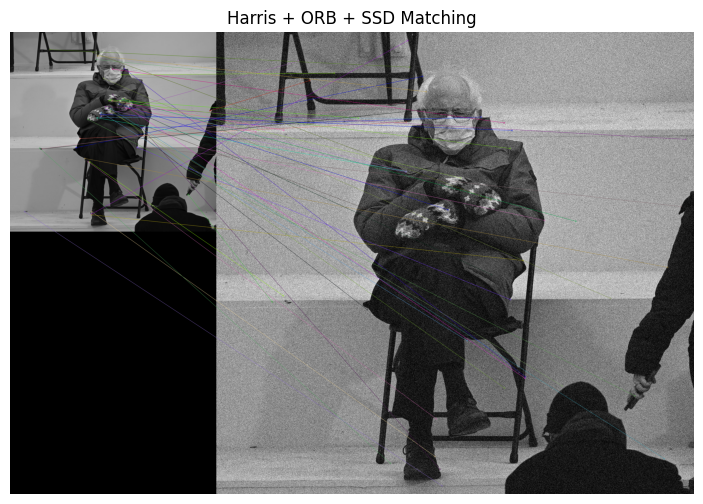

50


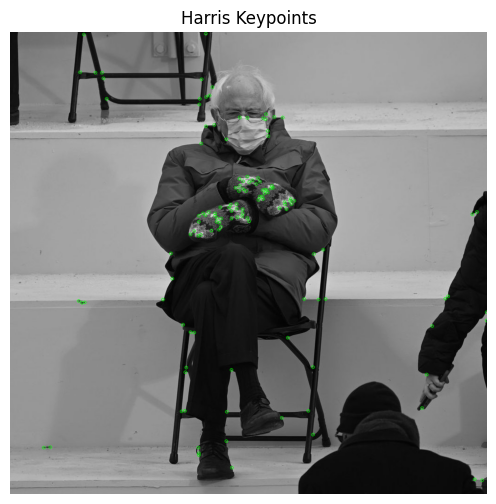

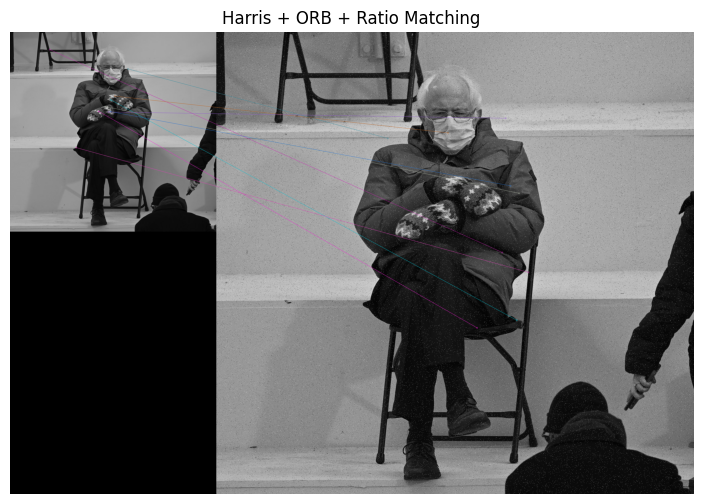

9


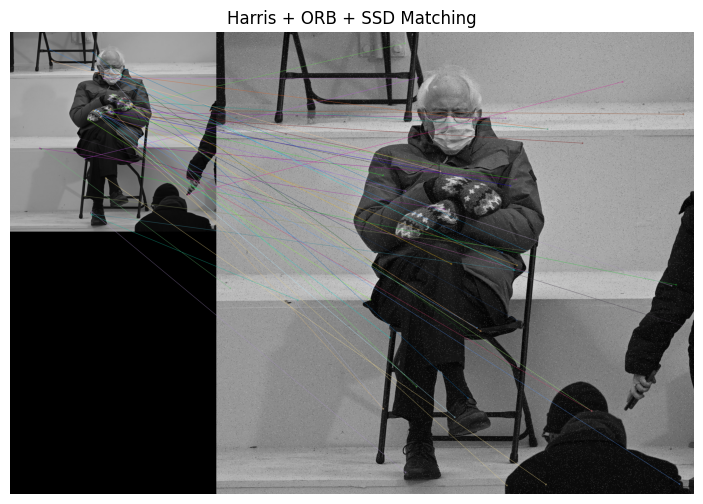

50


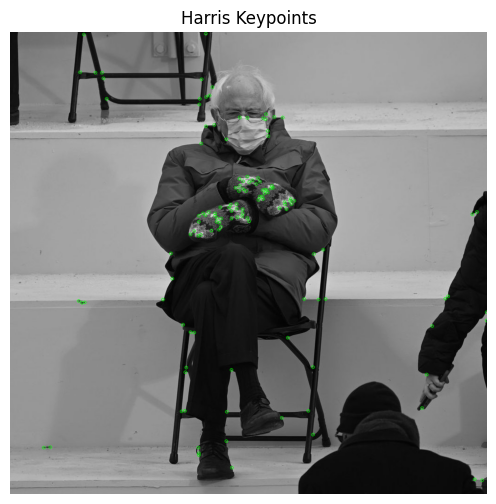

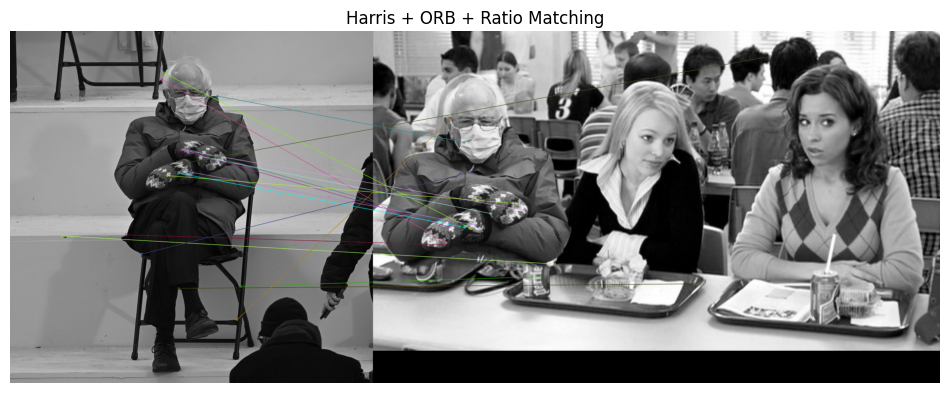

17


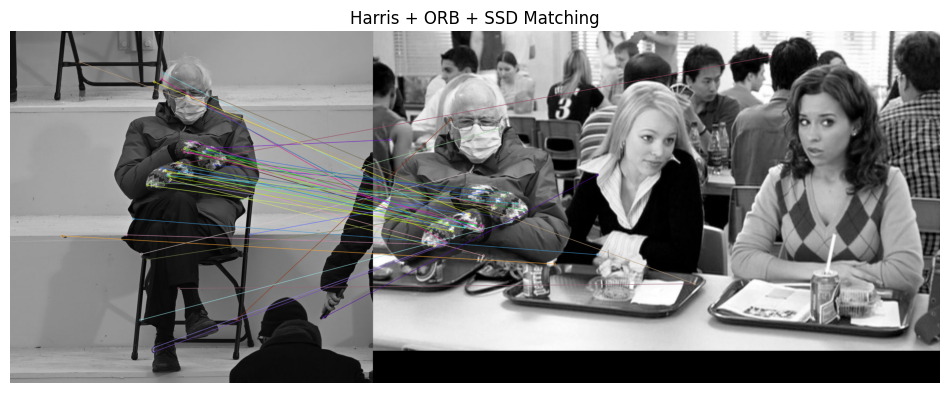

50


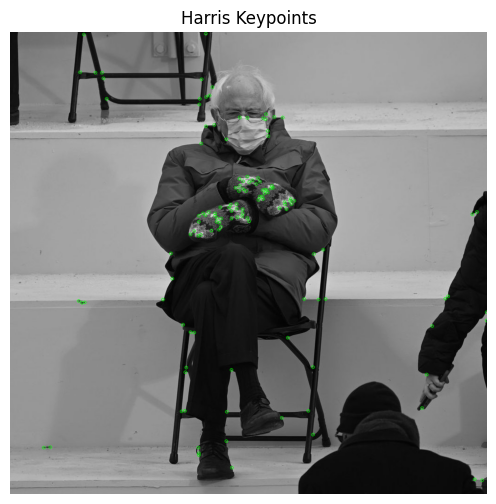

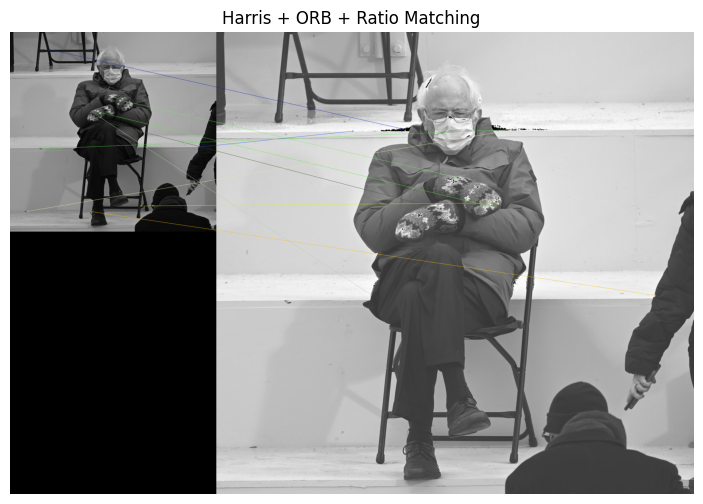

10


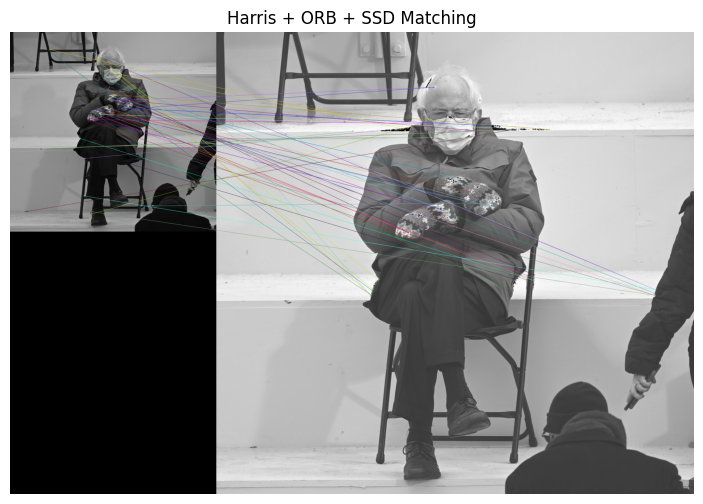

50


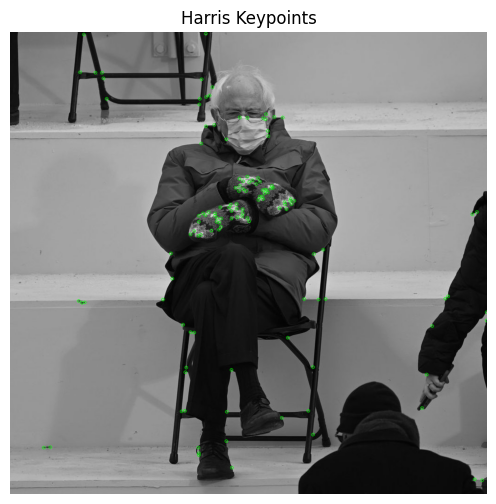

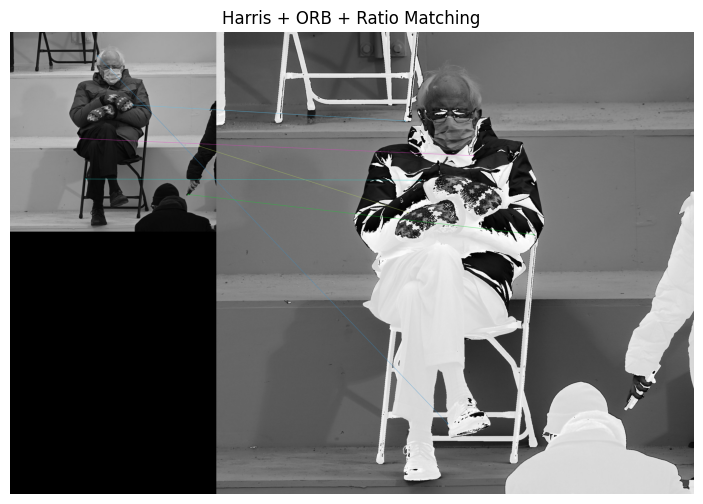

6


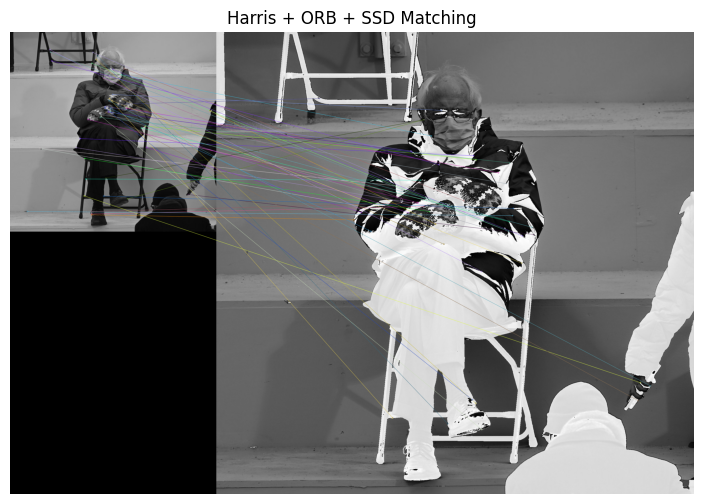

50


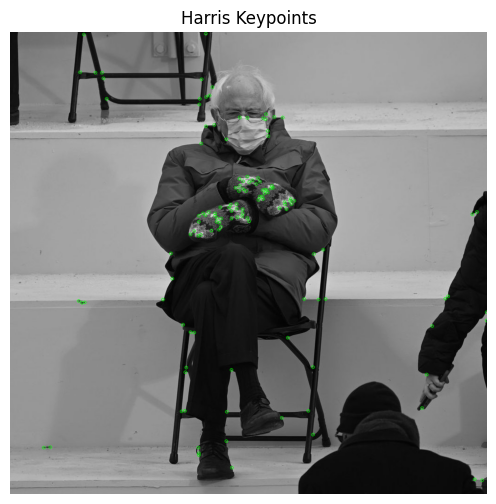

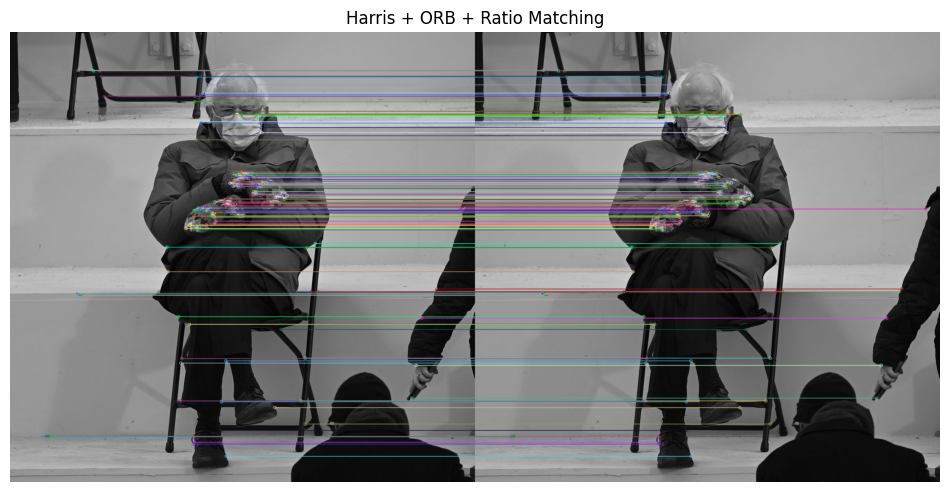

126


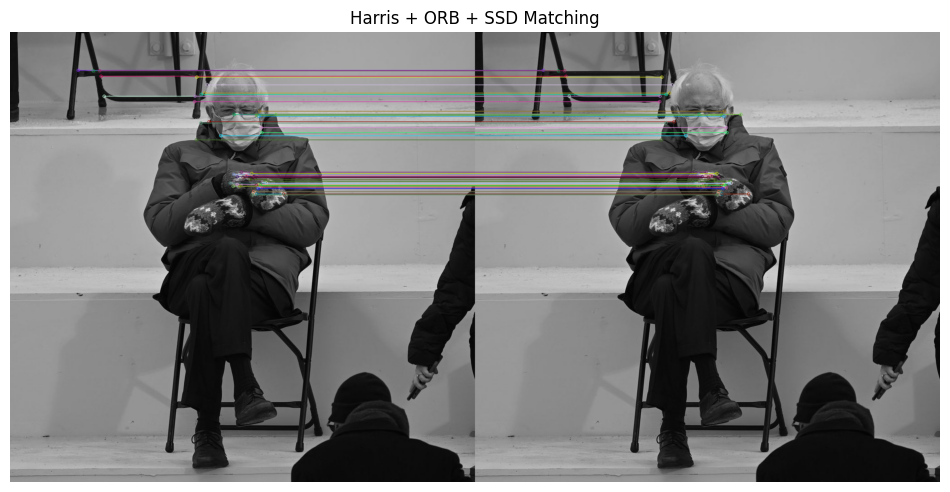

50


In [102]:
images=["bernie180.jpg", "bernieBenefitBeautySalon.jpeg", "BernieFriends.png", "bernieNoisy2.png", "berniePixelated2.png", "bernieShoolLunch.jpeg", "brighterBernie.jpg", "darkerBernie.jpg", "bernieSanders.jpeg"]
for img in images:
    compare_features(img)

In [94]:
def ORB_with_Harris(image):
    orb = cv2.ORB_create()
    # Use Harris detector (not FAST) internally
    orb.setFastThreshold(20)  # You can adjust this if needed
    orb.setEdgeThreshold(31)  # Default
    orb.setScoreType(cv2.ORB_HARRIS_SCORE)  # <-- Use Harris corners
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def ORB_with_FAST(image):
    orb = cv2.ORB_create()
    orb.setScoreType(cv2.ORB_FAST_SCORE)  # <-- Use FAST corners (default)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

503


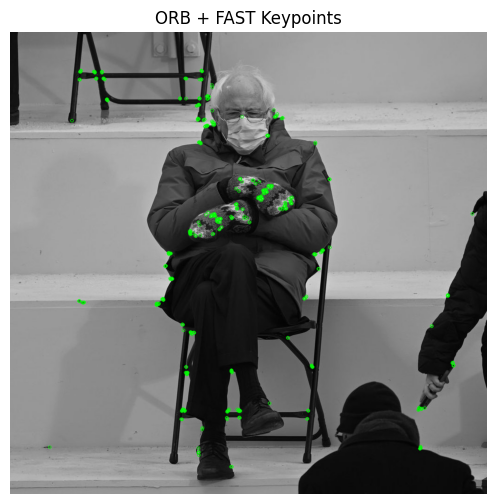

500


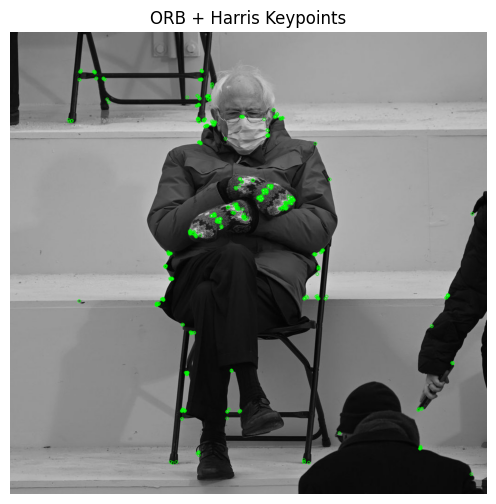

In [98]:
img = cv2.imread("images/bernieSanders.jpeg", cv2.IMREAD_GRAYSCALE)

# FAST-based ORB
kp_fast, desc_fast = ORB_with_FAST(img)
print(len(kp_fast))
show_keypoints(img, kp_fast, "ORB + FAST Keypoints")

# Harris-based ORB
kp_harris, desc_harris = ORB_with_Harris(img)
print(len(kp_harris))
show_keypoints(img, kp_harris, "ORB + Harris Keypoints")